In [1]:
import numpy as np
import os
import cv2
from tqdm import tqdm
from matplotlib import pyplot as plt
import time
from utilities import ROI, ImageTools, PlottingTools
import torch
from super_gradients.training import models
import glob

/home/yh6917/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[2023-05-29 12:07:29] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /home/yh6917/sg_logs/console.log


2023-05-29 12:07:30.823692: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-29 12:07:30.929555: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-29 12:07:31.385213: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/yh6917/.local/lib/python3.10/site-packages/cv2/../../lib64:/home/yh6917/nuws/inst

In [16]:
def calculate_errors(truth_path, estimated_path):
    # calculates errors in both translation and rotation
    # translation error unit in meters
    # rotation error unit in degrees/meter
    truth_path = np.array(truth_path)
    estimated_path = np.array(estimated_path)
    error_translation = np.linalg.norm(truth_path[:, :3, 3] - estimated_path[:, :3, 3], axis=1)
    error_rotation = np.linalg.norm(truth_path[:, :3, :3] - estimated_path[:, :3, :3], axis=(1, 2))
    # convert rotation error to degrees/meter
    error_rotation = np.rad2deg(error_rotation)
    # find difference between consecutive frames
    error_translation = np.diff(error_translation)
    error_rotation = np.diff(error_rotation)
    error_rotation = np.abs(error_rotation)
    return error_translation, error_rotation

In [3]:
class VisualOdometry():
    def __init__(self, data_path, feature_method="orb", match_threshold=0.5):
        self.K, self.P = self._load_calib(os.path.join(data_path, 'calib.txt'))
        self.groundtruth_poses = self._load_poses(os.path.join(data_path, 'poses.txt'))
        self.images = self._load_images(os.path.join(data_path, 'image_l'))
        self.feature_method = feature_method
        self.match_threshold = match_threshold
        if feature_method == "orb":
            self.feature_detector = cv2.ORB_create(3000)
            FLANN_INDEX_LSH = 6
            index_params = dict(algorithm=FLANN_INDEX_LSH, table_number=6, key_size=12, multi_probe_level=1)
            search_params = dict(checks=50)
        elif feature_method == "sift":
            self.feature_detector = cv2.SIFT_create()
            FLANN_INDEX_KDTREE = 1
            index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
            search_params = dict(checks=50)
        else:
            raise ValueError("Feature method not supported")

        self.flann = cv2.FlannBasedMatcher(indexParams=index_params, searchParams=search_params)

    @staticmethod
    def _load_calib(filepath):
        with open(filepath, 'r') as f:
            params = np.fromstring(f.readline(), dtype=np.float64, sep=' ')
            P = np.reshape(params, (3, 4))
            K = P[0:3, 0:3]
        return K, P
    
    @staticmethod
    def _load_poses(filepath):
        poses = []
        with open(filepath, 'r') as f:
            for line in f.readlines():
                T = np.fromstring(line, dtype=np.float64, sep=' ')
                T = T.reshape(3, 4)
                poses.append(T)
        return np.array(poses)

    @staticmethod
    def _load_images(filepath):
        images = []
        for filename in sorted(os.listdir(filepath)):
            img = cv2.imread(os.path.join(filepath, filename))
            images.append(img)
        return images
    
    @staticmethod
    def _form_transf(R, t):
        T = np.eye(4)
        T[:3, :3] = R
        T[:3, 3] = t
        return T
    
    def get_matches(self, i):
        kp1, des1 = self.feature_detector.detectAndCompute(self.images[i-1], None)
        kp2, des2 = self.feature_detector.detectAndCompute(self.images[i], None)
        if self.feature_method == "orb":
            matches = self.flann.knnMatch(des1, des2, k=2)
        elif self.feature_method == "sift":
            matches = self.flann.knnMatch(des1.astype(np.float32), des2.astype(np.float32), k=2)
        else:
            raise ValueError("Feature method not supported")

        good_matches = []
        for m, n in matches:
            if m.distance < self.match_threshold * n.distance:
                good_matches.append(m)
        
        q1 = np.array([kp1[m.queryIdx].pt for m in good_matches])
        q2 = np.array([kp2[m.trainIdx].pt for m in good_matches])

        return q1, q2
    
    def get_pose(self, q1, q2):
        # Essential, mask = cv2.findEssentialMat(q1, q2, self.K, cv2.RANSAC, 0.999, 1.0)
        Essential, mask = cv2.findEssentialMat(q1, q2, self.K)
        R, t = self.decompose(Essential, q1, q2)
        return self._form_transf(R, t)
    
    def decompose(self, Essential, q1, q2):
        R1, R2, t = cv2.decomposeEssentialMat(Essential)
        T1 = self._form_transf(R1,np.ndarray.flatten(t))
        T2 = self._form_transf(R2,np.ndarray.flatten(t))
        T3 = self._form_transf(R1,np.ndarray.flatten(-t))
        T4 = self._form_transf(R2,np.ndarray.flatten(-t))
        transformations = [T1, T2, T3, T4]
        K = np.concatenate(( self.K, np.zeros((3,1)) ), axis = 1)
        projections = [K @ T1, K @ T2, K @ T3, K @ T4]
        np.set_printoptions(suppress=True)
        positives = []
        for P, T in zip(projections, transformations):
            hom_Q1 = cv2.triangulatePoints(self.P, P, q1.T, q2.T)
            hom_Q2 = T @ hom_Q1
            Q1 = hom_Q1[:3, :] / hom_Q1[3, :]
            Q2 = hom_Q2[:3, :] / hom_Q2[3, :]  

            total_sum = sum(Q2[2, :] > 0) + sum(Q1[2, :] > 0)
            relative_scale = np.mean(np.linalg.norm(Q1.T[:-1] - Q1.T[1:], axis=-1) /
                                     (np.linalg.norm(Q2.T[:-1] - Q2.T[1:], axis=-1) + 1e-8))
            positives.append(total_sum + relative_scale)
        max = np.argmax(positives)
        if (max == 2):
            return R1, np.ndarray.flatten(-t)
        elif (max == 3):
            return R2, np.ndarray.flatten(-t)
        elif (max == 0):
            return R1, np.ndarray.flatten(t)
        elif (max == 1):
            return R2, np.ndarray.flatten(t)

    def get_trajectory(self):
        truth_path = []
        estimated_path = []
        for i, true_pose in enumerate(tqdm(self.groundtruth_poses, unit="frame")):
            if i == 0:
                current_pose = true_pose
            else:
                q1, q2 = self.get_matches(i)
                estimated_pose = self.get_pose(q1, q2)
                current_pose = np.matmul(current_pose, np.linalg.inv(estimated_pose))
            truth_path.append(true_pose)
            estimated_path.append(current_pose)
        return truth_path, estimated_path

    def plot_trajectory(self, truth_path, estimated_path):
        truth_path = np.array(truth_path)
        estimated_path = np.array(estimated_path)
        fig = plt.figure()
        # set figure size
        fig.set_size_inches(20, 10)
        # set axis ranges
        # plt.xlim((-2.5, 17.5))
        plt.plot(truth_path[:, 0, 3], truth_path[:, 2, 3], label='Ground Truth')
        plt.plot(estimated_path[:, 0, 3], estimated_path[:, 2, 3], label='Estimated')
        plt.legend()
        plt.show()

    def plot_error(self, truth_path, estimated_path):
        truth_path = np.array(truth_path)
        estimated_path = np.array(estimated_path)
        error = np.linalg.norm(truth_path[:, :3, 3] - estimated_path[:, :3, 3], axis=1)
        plt.plot(error)
        plt.show()

In [37]:
class VisualOdometryWithObjects():
    def __init__(self, data_path, feature_method="orb", match_threshold=0.5, iou_threshold=0.5, alpha=0.2):
        self.K, self.P = self._load_calib(os.path.join(data_path, 'calib.txt'))
        self.groundtruth_poses = self._load_poses(os.path.join(data_path, 'poses.txt'))
        self.images = self._load_images(os.path.join(data_path, 'image_l'))
        self.feature_method = feature_method
        self.match_threshold = match_threshold
        self.iou_threshold = iou_threshold
        self.alpha = alpha
        if feature_method == "orb":
            self.feature_detector = cv2.ORB_create(3000)
            FLANN_INDEX_LSH = 6
            index_params = dict(algorithm=FLANN_INDEX_LSH, table_number=6, key_size=12, multi_probe_level=1)
            search_params = dict(checks=50)
        elif feature_method == "sift":
            self.feature_detector = cv2.SIFT_create()
            FLANN_INDEX_KDTREE = 1
            index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
            search_params = dict(checks=50)
        else:
            raise ValueError("Feature method not supported")
        self.flann = cv2.FlannBasedMatcher(indexParams=index_params, searchParams=search_params)

        # object detection related setup
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model = models.get("yolo_nas_s", pretrained_weights="coco").to(self.device)
        self.last_bboxes = None
        self.last_labels = None

    @staticmethod
    def _load_calib(filepath):
        with open(filepath, 'r') as f:
            params = np.fromstring(f.readline(), dtype=np.float64, sep=' ')
            P = np.reshape(params, (3, 4))
            K = P[0:3, 0:3]
        return K, P
    
    @staticmethod
    def _load_poses(filepath):
        poses = []
        with open(filepath, 'r') as f:
            for line in f.readlines():
                T = np.fromstring(line, dtype=np.float64, sep=' ')
                T = T.reshape(3, 4)
                poses.append(T)
        return np.array(poses)

    @staticmethod
    def _load_images(filepath):
        images = []
        for filename in sorted(os.listdir(filepath)):
            img = cv2.imread(os.path.join(filepath, filename))
            images.append(img)
        return images
    
    @staticmethod
    def _form_transf(R, t):
        T = np.eye(4)
        T[:3, :3] = R
        T[:3, 3] = t
        return T
    
    def get_matches(self, i):
        kp1, des1 = self.feature_detector.detectAndCompute(self.images[i-1], None)
        kp2, des2 = self.feature_detector.detectAndCompute(self.images[i], None)
        if self.feature_method == "orb":
            matches = self.flann.knnMatch(des1, des2, k=2)
        elif self.feature_method == "sift":
            matches = self.flann.knnMatch(des1.astype(np.float32), des2.astype(np.float32), k=2)
        else:
            raise ValueError("Feature method not supported")

        good_matches = []
        for m, n in matches:
            if m.distance < self.match_threshold * n.distance:
                good_matches.append(m)
        
        q1 = np.array([kp1[m.queryIdx].pt for m in good_matches])
        q2 = np.array([kp2[m.trainIdx].pt for m in good_matches])

        return q1, q2
    
    def get_pose(self, q1, q2):
        # Essential, mask = cv2.findEssentialMat(q1, q2, self.K, cv2.RANSAC, 0.999, 1.0)
        Essential, mask = cv2.findEssentialMat(q1, q2, self.K)
        R, t = self.decompose(Essential, q1, q2)
        return self._form_transf(R, t)
    
    def decompose(self, Essential, q1, q2):
        R1, R2, t = cv2.decomposeEssentialMat(Essential)
        T1 = self._form_transf(R1,np.ndarray.flatten(t))
        T2 = self._form_transf(R2,np.ndarray.flatten(t))
        T3 = self._form_transf(R1,np.ndarray.flatten(-t))
        T4 = self._form_transf(R2,np.ndarray.flatten(-t))
        transformations = [T1, T2, T3, T4]
        K = np.concatenate(( self.K, np.zeros((3,1)) ), axis = 1)
        projections = [K @ T1, K @ T2, K @ T3, K @ T4]
        np.set_printoptions(suppress=True)
        positives = []
        for P, T in zip(projections, transformations):
            hom_Q1 = cv2.triangulatePoints(self.P, P, q1.T, q2.T)
            hom_Q2 = T @ hom_Q1
            Q1 = hom_Q1[:3, :] / hom_Q1[3, :]
            Q2 = hom_Q2[:3, :] / hom_Q2[3, :]  

            total_sum = sum(Q2[2, :] > 0) + sum(Q1[2, :] > 0)
            """
            relative_scale = np.mean(np.linalg.norm(Q1.T[:-1] - Q1.T[1:], axis=-1)/
                                     np.linalg.norm(Q2.T[:-1] - Q2.T[1:], axis=-1))
            """
            relative_scale = np.mean(np.linalg.norm(Q1.T[:-1] - Q1.T[1:], axis=-1) /
                                     (np.linalg.norm(Q2.T[:-1] - Q2.T[1:], axis=-1) + 1e-8))
            positives.append(total_sum + relative_scale)
        max = np.argmax(positives)
        if (max == 2):
            return R1, np.ndarray.flatten(-t)
        elif (max == 3):
            return R2, np.ndarray.flatten(-t)
        elif (max == 0):
            return R1, np.ndarray.flatten(t)
        elif (max == 1):
            return R2, np.ndarray.flatten(t)
    
    def get_objects(self, i):
        # prediction = self.model.predict(self.images[i])
        for item in self.model.predict(self.images[i], conf=0.6)._images_prediction_lst:
            bboxes = item.prediction.bboxes_xyxy
            labels = item.prediction.labels
            return bboxes, labels
        return None, None
    
    def match_objects(self, bboxes1, bboxes2, labels1, labels2):
        matches = []
        for i, bbox1 in enumerate(bboxes1):
            for j, bbox2 in enumerate(bboxes2):
                if labels1[i] == labels2[j]:
                    box1 = bbox1
                    box2 = bbox2
                    iou = self.compute_iou(box1, box2)
                    if iou > self.iou_threshold:
                        matches.append((i, j))
        return matches
    
    def compute_iou(self, box1, box2):
        """
        Computes IoU (Intersection over Union) between two bounding boxes
        IoU is a metric for evaluating simularity between two bounding boxes
        IoU is a value between 0 and 1, where 1 means the two bounding boxes are identical
        """
        x1, y1, x2, y2 = box1
        x3, y3, x4, y4 = box2
        x5, y5, x6, y6 = (max(x1, x3), max(y1, y3), min(x2, x4), min(y2, y4))
        if x5 > x6 or y5 > y6:
            return 0
        else:
            intersection = (x6 - x5) * (y6 - y5)
            union = (x2 - x1) * (y2 - y1) + (x4 - x3) * (y4 - y3) - intersection
            return intersection / union
    
    def get_pose_from_object(self, object_matches, new_bboxes):
        translations = []

        for match in object_matches:
            i, j = match
            bbox1 = self.last_bboxes[i]
            bbox2 = new_bboxes[j]

            centroid1 = np.array([(bbox1[0] + bbox1[2]) / 2, (bbox1[1] + bbox1[3]) / 2])
            centroid2 = np.array([(bbox2[0] + bbox2[2]) / 2, (bbox2[1] + bbox2[3]) / 2])

            translation = centroid2 - centroid1
            translations.append(translation)

        avg_translation = np.mean(translations, axis=0)
        R = np.eye(3)
        t = np.array([avg_translation[0], 0, avg_translation[1]])

        return self._form_transf(R, t)

    def get_trajectory(self):
        truth_path = []
        estimated_path = []
        for i, true_pose in enumerate(tqdm(self.groundtruth_poses, unit="frame")):
            if i == 0:
                current_pose = true_pose
                self.last_bboxes, self.last_labels = self.get_objects(i)
            else:
                q1, q2 = self.get_matches(i)
                estimated_pose_from_feature = self.get_pose(q1, q2)
                
                # object detection related code
                bboxes, labels = self.get_objects(i)
                object_matches = self.match_objects(self.last_bboxes, bboxes, self.last_labels, labels)
                # print(len(object_matches))
                if len(object_matches) > 0:
                    estimated_pose_from_object = self.get_pose_from_object(object_matches, bboxes)
                    # if estimated_pose_from_object is too large, we ignore it
                    object_pose_norm = np.linalg.norm(estimated_pose_from_object[:3, 3])
                    # print(object_pose_norm)
                    if object_pose_norm > 5.0:
                        estimated_pose = estimated_pose_from_feature
                    else:
                        estimated_pose = (1-self.alpha)*estimated_pose_from_feature + self.alpha*estimated_pose_from_object
                else:
                    estimated_pose = estimated_pose_from_feature
                self.last_bboxes = bboxes
                self.last_labels = labels

                current_pose = np.matmul(current_pose, np.linalg.inv(estimated_pose))
            truth_path.append(true_pose)
            estimated_path.append(current_pose)
        return truth_path, estimated_path

    def plot_trajectory(self, truth_path, estimated_path):
        truth_path = np.array(truth_path)
        estimated_path = np.array(estimated_path)
        fig = plt.figure()
        plt.plot(truth_path[:, 0, 3], truth_path[:, 2, 3], label='Ground Truth')
        plt.plot(estimated_path[:, 0, 3], estimated_path[:, 2, 3], label='Estimated')
        plt.legend()
        plt.show()

    def plot_error(self, truth_path, estimated_path):
        truth_path = np.array(truth_path)
        estimated_path = np.array(estimated_path)
        error = np.linalg.norm(truth_path[:, :3, 3] - estimated_path[:, :3, 3], axis=1)
        plt.plot(error)
        plt.show()

In [42]:
class VisualOdometryWithROI_Enhanced():
    def __init__(self, K, P, groundtruth_poses, images, feature_method="orb", match_threshold=0.5, roi_resolution=1200, roi_threshold_low=0, roi_threshold_high=1000) -> None:
        self.K = K
        self.P = P
        self.groundtruth_poses = groundtruth_poses
        self.images = images
        self.feature_method = feature_method
        if feature_method == "orb":
            self.feature_detector = cv2.ORB_create(3000)
            FLANN_INDEX_LSH = 6
            index_params = dict(algorithm=FLANN_INDEX_LSH, table_number=6, key_size=12, multi_probe_level=1)
            search_params = dict(checks=50)
        elif feature_method == "sift":
            self.feature_detector = cv2.SIFT_create()
            FLANN_INDEX_KDTREE = 1
            index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
            search_params = dict(checks=50)
        else:
            raise ValueError("Feature method not supported")
        self.flann = cv2.FlannBasedMatcher(indexParams=index_params, searchParams=search_params)

        # ROI related
        self.roi_object = ROI(max_dimension=roi_resolution,
                              roi_threshold_low=roi_threshold_low,
                              roi_threshold_high=roi_threshold_high)
        self.roi_object1 = ROI(max_dimension=1200,
                              roi_threshold_low=roi_threshold_low,
                              roi_threshold_high=roi_threshold_high)
        self.last_kp = None
        self.last_des = None
        self.match_threshold = match_threshold
        self.last_roi = None

        # for new enhancements
        self.current_transformation = np.eye(4)
    
    @staticmethod
    def _form_transf(R, t):
        T = np.eye(4)
        T[:3, :3] = R
        T[:3, 3] = t
        return T
    
    def get_matches(self, i):
        kp1, des1 = self.feature_detector.detectAndCompute(self.images[i-1], None)
        kp2, des2 = self.feature_detector.detectAndCompute(self.images[i], None)
        if self.feature_method == "orb":
            matches = self.flann.knnMatch(des1, des2, k=2)
        elif self.feature_method == "sift":
            matches = self.flann.knnMatch(des1.astype(np.float32), des2.astype(np.float32), k=2)
        else:
            raise ValueError("Feature method not supported")

        good_matches = []
        for m, n in matches:
            if m.distance < self.match_threshold * n.distance:
                good_matches.append(m)
        
        q1 = np.array([kp1[m.queryIdx].pt for m in good_matches])
        q2 = np.array([kp2[m.trainIdx].pt for m in good_matches])

        return q1, q2
    
    def get_matches_roi(self, i, roi):
        kp1 = self.last_kp
        des1 = self.last_des
        kp2, des2 = self.get_kp_des(i, roi)
        self.last_kp = kp2
        self.last_des = des2
        if self.feature_method == "orb":
            matches = self.flann.knnMatch(np.array(des1), np.array(des2), k=2)
        elif self.feature_method == "sift":
            matches = self.flann.knnMatch(np.array(des1).astype(np.float32), np.array(des2).astype(np.float32), k=2)
        else:
            raise ValueError("Feature method not supported")
        good_matches = []
        if len(matches) > 0:
            for m, n in matches:
                if m.distance < self.match_threshold * n.distance:
                    good_matches.append(m)
        q1 = np.array([kp1[m.queryIdx].pt for m in good_matches])
        q2 = np.array([kp2[m.trainIdx].pt for m in good_matches])
        return q1, q2, kp2
    
    def get_kp_des(self, i, rois):
        kp_list = []
        des_list = []
        for roi in rois:
            roi_img = self.images[i][roi[1]:roi[1]+roi[3], roi[0]:roi[0]+roi[2]]
            kp, des = self.feature_detector.detectAndCompute(roi_img, None)
            for k in kp:
                k.pt = (k.pt[0] + roi[0], k.pt[1] + roi[1])
            if len(kp) == 0:
                continue
            kp_list.extend(kp)
            des_list.extend(des)
        return kp_list, des_list
    
    def get_pose(self, q1, q2):
        # Essential, mask = cv2.findEssentialMat(q1, q2, self.K, cv2.RANSAC, 0.999, 1.0)
        Essential, _ = cv2.findEssentialMat(q1, q2, self.K)
        R, t = self.decompose(Essential, q1, q2)
        return self._form_transf(R, t)
    
    def decompose(self, Essential, q1, q2):
        R1, R2, t = cv2.decomposeEssentialMat(Essential)
        T1 = self._form_transf(R1,np.ndarray.flatten(t))
        T2 = self._form_transf(R2,np.ndarray.flatten(t))
        T3 = self._form_transf(R1,np.ndarray.flatten(-t))
        T4 = self._form_transf(R2,np.ndarray.flatten(-t))
        transformations = [T1, T2, T3, T4]
        K = np.concatenate(( self.K, np.zeros((3,1)) ), axis = 1)
        projections = [K @ T1, K @ T2, K @ T3, K @ T4]
        np.set_printoptions(suppress=True)
        positives = []
        for P, T in zip(projections, transformations):
            hom_Q1 = cv2.triangulatePoints(self.P, P, q1.T, q2.T)
            hom_Q2 = T @ hom_Q1
            Q1 = hom_Q1[:3, :] / hom_Q1[3, :]
            Q2 = hom_Q2[:3, :] / hom_Q2[3, :]  
            total_sum = sum(Q2[2, :] > 0) + sum(Q1[2, :] > 0)
            relative_scale = np.mean(np.linalg.norm(Q1.T[:-1] - Q1.T[1:], axis=-1) /
                                     (np.linalg.norm(Q2.T[:-1] - Q2.T[1:], axis=-1) + 1e-8))
            positives.append(total_sum + relative_scale)
        max = np.argmax(positives)
        if (max == 2):
            return R1, np.ndarray.flatten(-t)
        elif (max == 3):
            return R2, np.ndarray.flatten(-t)
        elif (max == 0):
            return R1, np.ndarray.flatten(t)
        elif (max == 1):
            return R2, np.ndarray.flatten(t)
    
    def filter_roi_with_IoU(self, rois):
        new_rois = []
        for roi in rois:
            if len(new_rois) == 0:
                new_rois.append(roi)
            else:
                iou = []
                for new_roi in new_rois:
                    iou.append(self._get_iou(roi, new_roi))
                if max(iou) < 0.5:
                    new_rois.append(roi)
        return new_rois
    
    def _get_iou(self, roi1, roi2):
        x1 = max(roi1[0], roi2[0])
        y1 = max(roi1[1], roi2[1])
        x2 = min(roi1[0] + roi1[2], roi2[0] + roi2[2])
        y2 = min(roi1[1] + roi1[3], roi2[1] + roi2[3])
        intersection = max(0, x2 - x1) * max(0, y2 - y1)
        union = roi1[2] * roi1[3] + roi2[2] * roi2[3] - intersection
        return intersection / union

    def get_trajectory(self):
        truth_path = []
        estimated_path = []
        time_array1 = []
        time_array2 = []
        for i, true_pose in enumerate(tqdm(self.groundtruth_poses, unit="frame")):
            if i == 0:
                current_pose = true_pose
                roi = self.roi_object.get_rois(self.images[i])
                self.last_kp, self.last_des = self.get_kp_des(i, roi)
            else:
                # time1 = time.time()
                roi = self.roi_object.get_rois(self.images[i])
                # roi = self.filter_roi_with_IoU(roi)
                
                q1, q2, new_keypoints = self.get_matches_roi(i, roi)
                # self.plot_roi_and_keypoints(i, roi, new_keypoints)
                
                # time2 = time.time()
                # _ = self.roi_object1.get_rois(self.images[i])
                # q11, q22 = self.get_matches(i)
                # time_array2.append(time.time() - time2)
                new_transformation = self.get_pose(q1, q2)
                # time_array1.append(time.time() - time1)



                # time2 = time.time()
                # _ = self.roi_object.get_rois(self.images[i])              
                # q11, q22, new_keypoints = self.get_matches_roi(i, roi)
                # self.plot_roi_and_keypoints(i, roi, new_keypoints)
                # new_transformation1 = self.get_pose(q1, q2)
                # time_array2.append(time.time() - time2)

                # weigh the new transformation with the previous one
                # filtered_transformation = new_transformation
                filtered_transformation = self.current_transformation * 0.5 + new_transformation * 0.5
                
                current_pose = np.matmul(current_pose, np.linalg.inv(filtered_transformation))
                self.current_transformation = new_transformation
            truth_path.append(true_pose)
            estimated_path.append(current_pose)
        return truth_path, estimated_path
    
    def plot_roi_and_keypoints(self, i, roi, keypoints):
        img = self.images[i].copy()
        for r in roi:
            cv2.rectangle(img, (r[0], r[1]), (r[0]+r[2], r[1]+r[3]), (0, 255, 0), 2)
        img = cv2.drawKeypoints(img, keypoints, None, color=(0, 255, 0), flags=0)
        # use a cv2 window to display images
        cv2.imshow('ROI & keypoints', img)
        cv2.waitKey(200)

In [2]:
data_path = "KITTI_sequence_1"
image_tools = ImageTools(data_path)
K, P, path, images = image_tools.read_all()


In [4]:
translation_errors = []
rotation_errors = []
run_times = []
run_time_orb = []
run_time_sift = []
for i in range(1, 10):
    curr_time = time.time()
    vo = VisualOdometry(data_path, feature_method='orb')
    truth_path, estimated_path = vo.get_trajectory()
    run_time_orb.append(time.time() - curr_time)
    curr_time = time.time()
    vo = VisualOdometry(data_path, feature_method='sift')
    truth_path, estimated_path = vo.get_trajectory()
    run_time_sift.append(time.time() - curr_time)
    # vo = VisualOdometryWithObjects(data_path, feature_method='sift')
    """
    vo = VisualOdometryWithROI_Enhanced(K,
                                        P, 
                                        path, 
                                        images, 
                                        feature_method="sift", 
                                        roi_resolution=1200, 
                                        roi_threshold_low=10, 
                                        roi_threshold_high=1000)
    """
    
    # error_translation, error_rotation = calculate_errors(truth_path, estimated_path)
    # translation_errors.append(np.average(error_translation))
    # rotation_errors.append(np.average(error_rotation))
    # run_times.append(time.time() - curr_time)

 98%|█████████▊| 50/51 [00:18<00:00,  2.81frame/s]

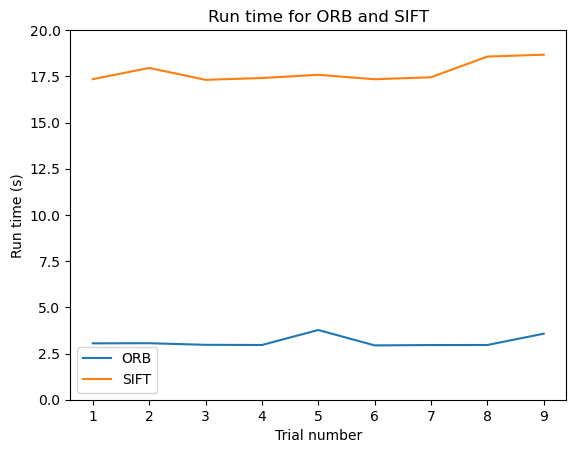

In [6]:
# plot both run_time_orb and run_time_sift on the same plot
plt.plot(range(1, 10), run_time_orb, label='ORB')
plt.plot(range(1, 10), run_time_sift, label='SIFT')
plt.xlabel('Trial number')
plt.ylabel('Run time (s)')
# set y axis limit
plt.ylim(0, 20)
plt.title('Run time for ORB and SIFT')
plt.legend()
plt.show()

In [44]:
np.average(translation_errors)

100%|██████████| 51/51 [00:09<00:00,  5.64frame/s]


0.20763492103907144

In [45]:
np.average(rotation_errors)

0.057792513291024465

In [46]:
np.average(run_times)

8.855145454406738

In [48]:
motion_errors = [0.19774, 0.21509, 0.29486, 0.19785, 0.19765, 0.20763]
average_runtime = [18.47078, 3.25652, 30.25726, 5.60529, 8.55820, 8.85514]
methods = ["VO SIFT", "VO ORB", "Object VO", "ROI-SIFT 1", "ROI-SIFT 2", "ROI-SIFT 3"]

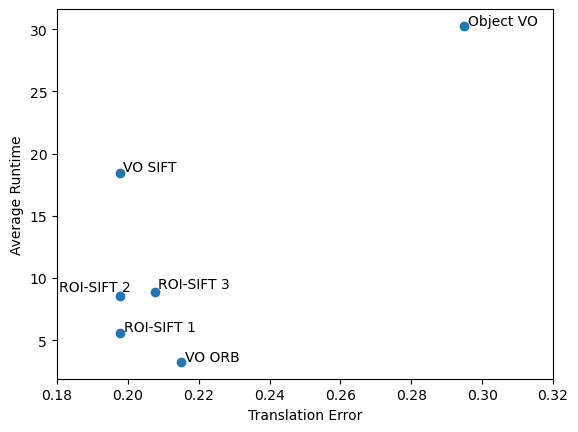

In [66]:
# draw a 2D scatter plot of the motion errors and the runtimes
# mark each point with a different color
# add a legend
# add axis labels

plt.scatter(motion_errors, average_runtime)
for i, method in enumerate(methods):
    offset = 0.1
    offset1 = 0.001
    if method=='ROI-SIFT 2':
        offset = 0.4
        offset1 = -0.017
    elif method=='ROI-SIFT 3':
        offset = 0.3
    plt.annotate(method, (motion_errors[i], average_runtime[i]), xytext=(motion_errors[i]+offset1, average_runtime[i]+offset))
# set x axis limits
plt.xlim(0.18, 0.32)
plt.xlabel("Translation Error")
plt.ylabel("Average Runtime")
plt.show()